In [57]:
import xarray as xr
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
from os import path
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer
from plot_tools import *
from analysis_tools import *

In [2]:
gfdlesm2g_files = '/Volumes/DataDrive/Met2GradData/rcp45-GFDL-ESM2G/'

gfdl_temp = path.join(gfdlesm2g_files,'ta_day_GFDL-ESM2G_rcp45_r1i1p1_20710101-20751231.nc')
gfdl_uwind = path.join(gfdlesm2g_files,'ua_day_GFDL-ESM2G_rcp45_r1i1p1_20710101-20751231.nc')
gfdl_vwind = path.join(gfdlesm2g_files,'va_day_GFDL-ESM2G_rcp45_r1i1p1_20710101-20751231.nc')
gfdl_gp = path.join(gfdlesm2g_files,'zg_day_GFDL-ESM2G_rcp45_r1i1p1_20710101-20751231.nc')

In [3]:
temp = xr.open_dataset(gfdl_temp)
uwind = xr.open_dataset(gfdl_uwind)
vwind = xr.open_dataset(gfdl_vwind)
gp = xr.open_dataset(gfdl_gp)

/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_44104/2655856887.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  temp = xr.open_dataset(gfdl_temp)
/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_44104/2655856887.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  uwind = xr.open_dataset(gfdl_uwind)
/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_44104/2655856887.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vwind = xr.open_dataset(gfdl_vwind)
/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T

In [4]:
# Merge all the datasets into one dataset
ds_raw = xr.merge([gp, temp, uwind, vwind])

# We just want the southern hemisphere from 45S to the southern pole
ds = ds_raw.sel(lat=slice(-90, -45))

In [5]:
# Define the polar stereographic projection for the South Pole
#south_pole_proj = Proj(proj='stere', lat_ts=-71, lat_0=-90, lon_0=0, ellps='WGS84')

# Convert lat/lon to 2D arrays
lats = ds['lat'].values
lons = ds['lon'].values

# If 1D, make 2D meshgrid
lon2d, lat2d = np.meshgrid(lons, lats)

# Transform to x, y (in meters)
#x, y = south_pole_proj(lon2d, lat2d)

# Add x and y as new coordinates
#ds = ds.assign_coords({'x': (('lat', 'lon'), x),
#                       'y': (('lat', 'lon'), y)})

In [6]:
# Select variables
Z = ds['zg']  # Geopotential height [m]
U = ds['ua']  # Zonal wind [m/s]
V = ds['va']  # Meridional wind [m/s]
T = ds['ta']  # Temperature [K]
lat = ds['lat']
lon = ds['lon']
lev = ds['plev']  # Pressure levels (Pa)
time = ds['time']

In [7]:
# Define constants
omega = 7.2921e-5  # Earth's rotation rate [s^-1]
R = 287.0  # Gas constant for dry air [J/(kg*K)]
g = 9.81  # Gravity [m/s^2]
f0 = 2 * omega * np.sin(np.deg2rad(lat))  # Coriolis parameter

# Compute streamfunction ψ
psi = (Z / g) * (lev / f0)

In [8]:
# Assuming lat and lon are 1D arrays, and psi is a 2D DataArray with dims ('lat', 'lon')
lon2d, lat2d = np.meshgrid(lon, lat)

# Convert degrees to radians and compute dx, dy as 2D arrays
R = 6371000  # Earth radius [m]
dx = np.gradient(lon) * (np.pi / 180) * R * np.cos(np.deg2rad(lat2d))  # shape: (lat, lon)
dy = np.gradient(lat) * (np.pi / 180) * R  # shape: (lat,)

# Broadcast dy to 2D to match shape
dy2d = np.broadcast_to(dy[:, np.newaxis], dx.shape)

# Compute second derivatives using xarray DataArray operations (assuming psi is a DataArray)
d2psi_dx2 = (psi.shift(lon=-1) - 2 * psi + psi.shift(lon=1)) / (dx ** 2)
d2psi_dy2 = (psi.shift(lat=-1) - 2 * psi + psi.shift(lat=1)) / (dy2d ** 2)

laplacian_psi = d2psi_dx2 + d2psi_dy2

In [9]:
# Ensure lev is a coordinate
T = T.assign_coords(lev=lev)
psi = psi.assign_coords(lev=lev)

# Compute potential temperature
theta = T * (100000 / T.lev) ** (R / 1004)

# Compute d(log(theta))/dp along 'lev' (pressure) dimension
log_theta = np.log(theta)
dtheta_dp = log_theta.differentiate('lev')

# Static stability parameter sigma
sigma = -(R * T / T.lev) * dtheta_dp

# Vertical derivatives of psi
dpsi_dp = psi.differentiate('lev')
d2psi_dp2 = dpsi_dp.differentiate('lev')

# QGPV vertical term
QGPV_vertical = ((f0**2 / sigma) * dpsi_dp).differentiate('lev')

/Users/ryaneagan/opt/anaconda3/envs/metanalysis/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1298: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/ryaneagan/opt/anaconda3/envs/metanalysis/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1298: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/ryaneagan/opt/anaconda3/envs/metanalysis/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1314: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


In [10]:
# Compute full QGPV
QGPV = laplacian_psi + f0 + QGPV_vertical

In [11]:
# Z should be an xarray.DataArray with coordinates 'lat' and 'lon'
# Assign lat/lon as coordinates if not already
Z = Z.assign_coords(lat=lat, lon=lon)

# Compute geostrophic winds using derivatives
ug = - (1 / f0) * Z.differentiate('lat') * (np.pi / 180) * 6371000  # dΦ/dy
vg = (1 / f0) * Z.differentiate('lon') * (np.pi / 180) * 6371000 * np.cos(np.deg2rad(Z.lat))

In [12]:
# Compute Geostrophic Vorticity
dvg_dx = vg.differentiate('lon') * (np.pi / 180) * 6371000 * np.cos(np.deg2rad(Z.lat))
dug_dy = ug.differentiate('lat') * (np.pi / 180) * 6371000
zeta_g = dvg_dx - dug_dy

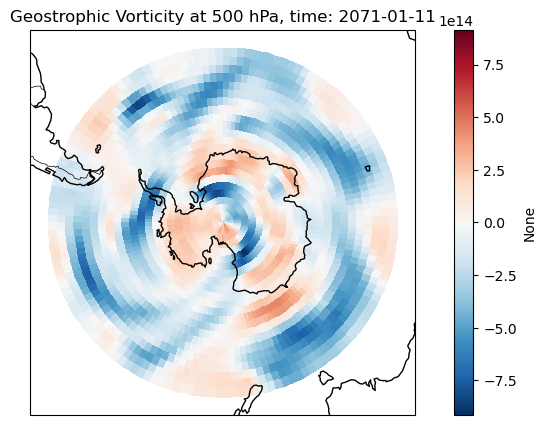

In [15]:
plot_field(zeta_g, "Geostrophic Vorticity", time_idx=10, level_value=50000, cmap="RdBu_r", prj='SouthPolarStereo')

In [16]:
# Compute the Rossby Wave Source

dU_dx = U.differentiate('lon') * (np.pi / 180) * 6371000 * np.cos(np.deg2rad(Z.lat))
dV_dy = V.differentiate('lat') * (np.pi / 180) * 6371000
dvg_dy = vg.differentiate('lat') * (np.pi / 180) * 6371000

rws = - (zeta_g * dU_dx + dV_dy) - f0 * dvg_dy

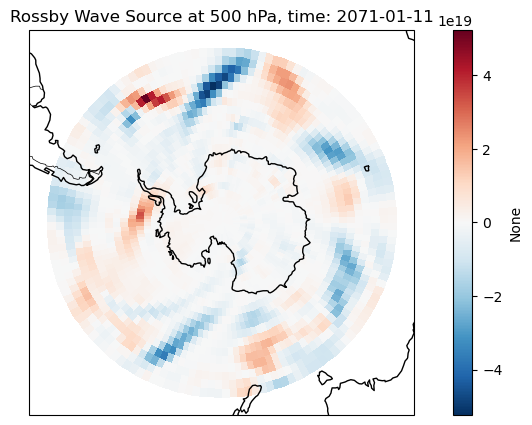

In [17]:
plot_field(rws, "Rossby Wave Source", time_idx=10, level_value=50000, cmap="RdBu_r", prj='SouthPolarStereo')

In [18]:
# Compute Rossby Wave Tendency

# Ensure QGPV has time coordinate as datetime64
QGPV['time'] = time  # if not already assigned

# Compute temporal derivative
QGPV_tendency = QGPV.differentiate('time')  # units: 1/s if time is in datetime64

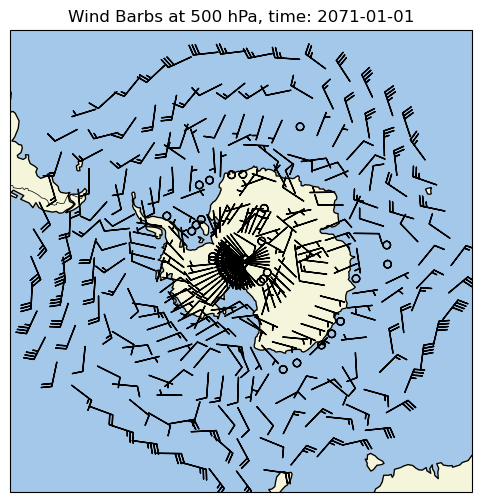

In [19]:
plot_wind_barbs(U, V, time_idx=0, level_value=50000, stride=3, prj='SouthPolarStereo')

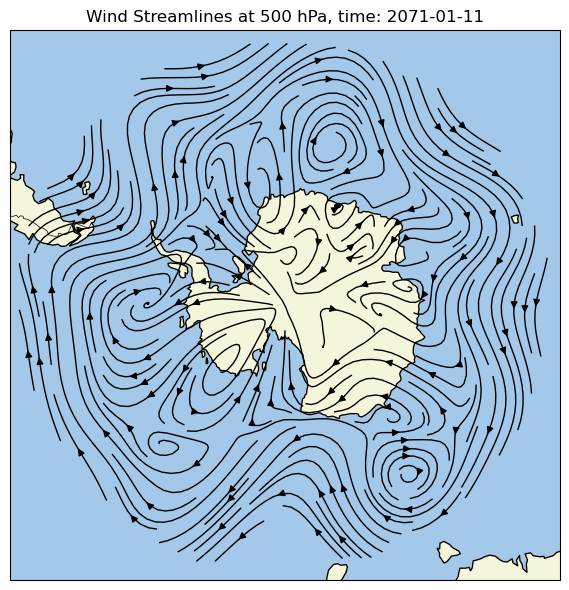

In [28]:
plot_wind_streamlines(U, V, time_idx=10, level_value=50000, density=2, prj='SouthPolarStereo')

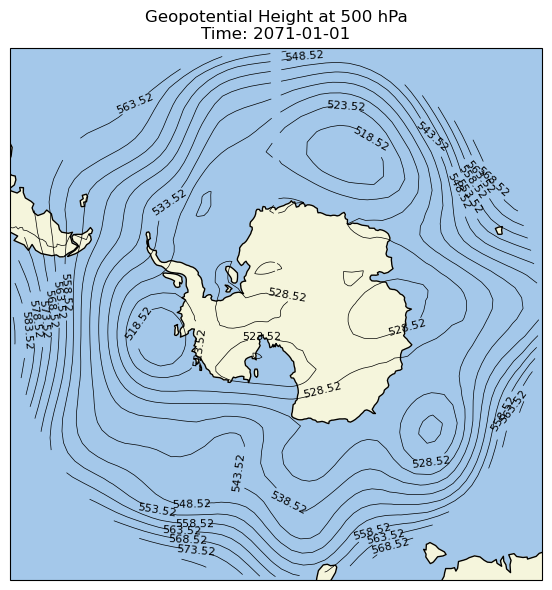

In [29]:
plot_geopotential_contours(Z, time_idx=0, level_value=50000, prj='SouthPolarStereo')

Function below to do all this magic

In [58]:
# Compute EOFs from geopotential Z at 500 hPa
# Let's say Z has dims: ('time', 'plev', 'lat', 'lon')
pca, eofs, pcs = compute_eofs_general(
    zeta_g,
    time_dim='time',
    spatial_dims=('lat', 'lon'),
    level_dim='plev',
    level_value=50000,  # 500 hPa
    n_modes=3
)

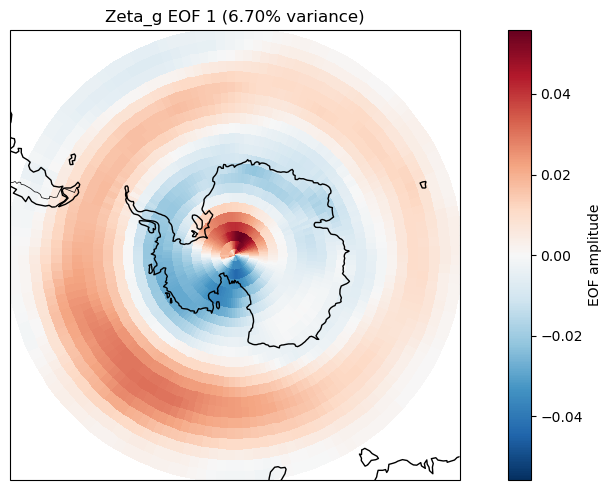

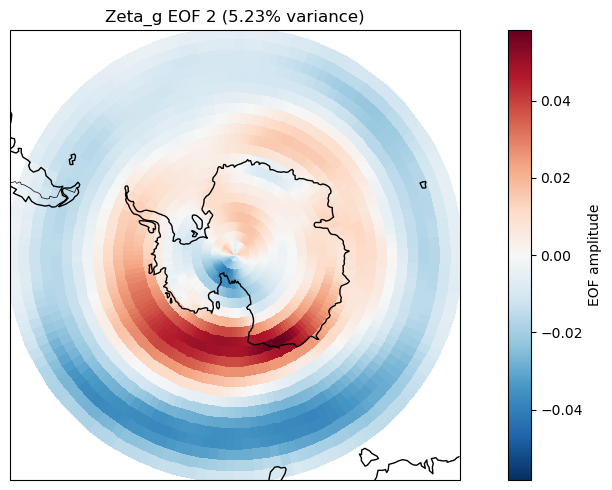

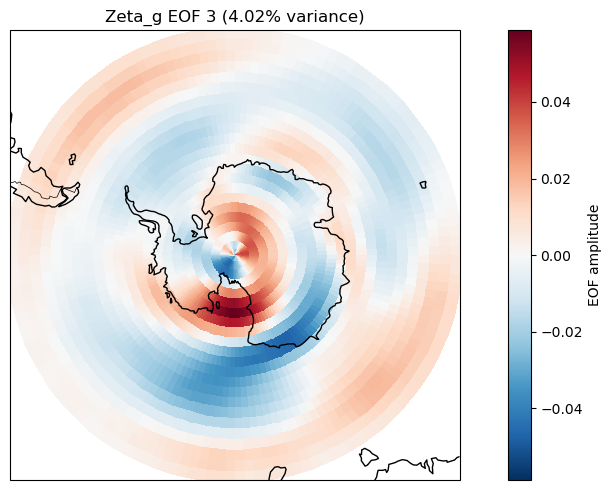

In [59]:
# Plot first 3 EOFs
for i, eof in enumerate(eofs):
    plot_eof(eof, title=f"Zeta_g EOF {i+1} ({pca.explained_variance_ratio_[i]*100:.2f}% variance)", prj='SouthPolarStereo')

In [ ]:
# pcs.sel(mode=1).plot.line(label='PC1')
# pcs.sel(mode=2).plot.line(label='PC2')
# plt.legend()
# plt.title("Principal Components")
# plt.show()